---
title: SHAP explainers for SCANVI
date: 15-08-2023
author: Martin Proks
---

In this notebook we have tried to modify the SHAP to accept `SCVI/SCANVI` object. Withing the tool, there are two option which can be used.

**KernelExplainer** which is agnostic to the model, only requires a prediction function and input. The problem is that it's **very slow**.

Alternative approach which is recommended when dealign with NN is to use the DeepExplainer (supports both PyTorch and Tensorflow).

**DeepExplainer** will propage through the network and extract the weights and then will determine after penalization which features are the crucial one for classification.

In [1]:
!which pip

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
%matplotlib inline

import scvi
import scgen
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

scvi.settings.seed = 0

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0


In [3]:
%run ../scripts/deep_scanvi.py

In [4]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
lvae

INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.005, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [23]:
import anndata
import torch
from sklearn.model_selection import train_test_split


def train_test_group_split(adata: anndata.AnnData, groupby: str):
    """
    Function to split anndata object 80/20 per group in format
    required for SCANVIDeep explainer.
    """
    groups = adata.obs.groupby(groupby)
    train, test = [], []
    for _, cells in groups.groups.items():
        train_test = train_test_split(cells.values, test_size=0.1)
        
        train.append(train_test[0])
        test.append(train_test[1])

    train, test = np.concatenate(train), np.concatenate(test)

    X_train = {
        'X': torch.from_numpy(adata[train].layers['counts'].A).type(torch.DoubleTensor),
        'batch': torch.from_numpy(adata[train].obs.batch.cat.codes.values[:, np.newaxis]),
        'labels': torch.from_numpy(adata[train].obs.ct.cat.codes.values[:, np.newaxis])
    }

    X_test = {
        'X': torch.from_numpy(adata[test].layers['counts'].A).type(torch.DoubleTensor),
        'batch': torch.from_numpy(adata[test].obs.batch.cat.codes.values[:, np.newaxis]),
        'labels': torch.from_numpy(adata[test].obs.ct.cat.codes.values[:, np.newaxis])
    }
    
    return X_train, X_test


def feature_plot(X_test, shap_values: np.ndarray, classes: pd.Index, features: np.ndarray, subset: bool = False):
    """
    Prints feature contribution (absolute mean SHAP value) for each cell type (top 10).

    X_test: 
        test dataset
    shap_values: 
        SHAP values
    classes: 
        list of classifiers (cell types in this case)
    features: 
        list of genes (HVGs)
    subset: 
        If True calculate contribution by subsetting for test cells which belong to that particual classifier
        Else Be generic and return contributing features even when testing set has different cell types
    """
    fig, ax = plt.subplots(7, 2, sharex=False, figsize=[20, 40])
    
    for idx, ct in enumerate(classes):
    
        shaps = pd.DataFrame(shap_values[idx], columns=features)

        if subset:
            shaps['ct'] = X_test['labels']
            shaps = shaps.query('ct == @idx').iloc[:, :-1]

            tmp_avg = shaps\
                .mean(axis=0)\
                .sort_values(ascending=False)\
                .reset_index()\
                .rename(columns={'index':'feature',0:'weight'})\
            
            positive = tmp_avg.query('weight > 0').head(5)
            negative = tmp_avg.query('weight < 0').tail(5)

            avg = pd.concat([positive, negative])
            title = f'Mean(SHAP value average importance for: {ct}'
            
        else:
            avg = shaps\
                .abs()\
                .mean(axis=0)\
                .sort_values(ascending=False)\
                .reset_index()\
                .rename(columns={'index':'feature',0:'weight'})\
                .query('weight > 0')\
                .head(10)
            title = f'Mean(|SHAP value|) average importance for: {ct}'
    
        sns.barplot(x='weight', y='feature', data=avg, ax=ax[idx // 2, idx % 2])
        ax[idx // 2, idx % 2].set_title(title)

In [6]:
background, test = train_test_group_split(lvae.adata, groupby='ct')

## KernelExplainer

In [ ]:
from anndata import AnnData
from tqdm import tqdm
from shap.explainers._kernel import Kernel
from shap.utils._legacy import (
    IdentityLink,
    convert_to_instance_with_index,
    convert_to_instance,
    match_instance_to_data,
)
from scipy.special import binom

import copy
import logging
import pandas as pd
import itertools
import numpy as np

log = logging.getLogger("shap")
BATCH = "batch"


class SCANVIExplainer(Kernel):
    def __init__(self, model, adata: AnnData, link=IdentityLink(), **kwargs):

        # self.batch = adata.obs[BATCH]
        data = adata.to_df()

        super().__init__(model, data, link=IdentityLink(), **kwargs)

    def explain(self, incoming_instance, **kwargs):

        index_hardcode = kwargs.get("index_hardcode")
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)

        # find the feature groups we will test. If a feature does not change from its
        # current value then we know it doesn't impact the model

        self.varyingInds = self.varying_groups(instance.x)
        if self.data.groups is None:
            self.varyingFeatureGroups = np.array([i for i in self.varyingInds])
            self.M = self.varyingFeatureGroups.shape[0]
        else:
            self.varyingFeatureGroups = [self.data.groups[i] for i in self.varyingInds]
            self.M = len(self.varyingFeatureGroups)
            groups = self.data.groups
            # convert to numpy array as it is much faster if not jagged array (all groups of same length)
            if self.varyingFeatureGroups and all(
                len(groups[i]) == len(groups[0]) for i in self.varyingInds
            ):
                self.varyingFeatureGroups = np.array(self.varyingFeatureGroups)
                # further performance optimization in case each group has a single value
                if self.varyingFeatureGroups.shape[1] == 1:
                    self.varyingFeatureGroups = self.varyingFeatureGroups.flatten()

        # find f(x)
        if self.keep_index:
            # pass_df = instance.convert_to_df()
            pass_df = pd.DataFrame(instance.x, index=index_hardcode)
            # pass_df.index = index_hardcode
            # display(pass_df)
            model_out = self.model.f(pass_df)
        else:
            model_out = self.model.f(instance.x)
        if isinstance(model_out, (pd.DataFrame, pd.Series)):
            model_out = model_out.values
        self.fx = model_out[0]

        if not self.vector_out:
            self.fx = np.array([self.fx])

        # if no features vary then no feature has an effect
        if self.M == 0:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))

        # if only one feature varies then it has all the effect
        elif self.M == 1:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            diff = self.link.f(self.fx) - self.link.f(self.fnull)
            for d in range(self.D):
                phi[self.varyingInds[0], d] = diff[d]

        # if more than one feature varies then we have to do real work
        else:
            self.l1_reg = kwargs.get("l1_reg", "auto")

            # pick a reasonable number of samples if the user didn't specify how many they wanted
            self.nsamples = kwargs.get("nsamples", "auto")
            if self.nsamples == "auto":
                self.nsamples = 2 * self.M + 2**11

            # if we have enough samples to enumerate all subsets then ignore the unneeded samples
            self.max_samples = 2**30
            if self.M <= 30:
                self.max_samples = 2**self.M - 2
                if self.nsamples > self.max_samples:
                    self.nsamples = self.max_samples

            # reserve space for some of our computations
            self.allocate()

            # weight the different subset sizes
            num_subset_sizes = np.int(np.ceil((self.M - 1) / 2.0))
            num_paired_subset_sizes = np.int(np.floor((self.M - 1) / 2.0))
            weight_vector = np.array(
                [
                    (self.M - 1.0) / (i * (self.M - i))
                    for i in range(1, num_subset_sizes + 1)
                ]
            )
            weight_vector[:num_paired_subset_sizes] *= 2
            weight_vector /= np.sum(weight_vector)
            log.debug("weight_vector = {0}".format(weight_vector))
            log.debug("num_subset_sizes = {0}".format(num_subset_sizes))
            log.debug("num_paired_subset_sizes = {0}".format(num_paired_subset_sizes))
            log.debug("M = {0}".format(self.M))

            # fill out all the subset sizes we can completely enumerate
            # given nsamples*remaining_weight_vector[subset_size]
            num_full_subsets = 0
            num_samples_left = self.nsamples
            group_inds = np.arange(self.M, dtype="int64")
            mask = np.zeros(self.M)
            remaining_weight_vector = copy.copy(weight_vector)
            for subset_size in range(1, num_subset_sizes + 1):

                # determine how many subsets (and their complements) are of the current size
                nsubsets = binom(self.M, subset_size)
                if subset_size <= num_paired_subset_sizes:
                    nsubsets *= 2
                log.debug("subset_size = {0}".format(subset_size))
                log.debug("nsubsets = {0}".format(nsubsets))
                log.debug(
                    "self.nsamples*weight_vector[subset_size-1] = {0}".format(
                        num_samples_left * remaining_weight_vector[subset_size - 1]
                    )
                )
                log.debug(
                    "self.nsamples*weight_vector[subset_size-1]/nsubsets = {0}".format(
                        num_samples_left
                        * remaining_weight_vector[subset_size - 1]
                        / nsubsets
                    )
                )

                # see if we have enough samples to enumerate all subsets of this size
                if (
                    num_samples_left
                    * remaining_weight_vector[subset_size - 1]
                    / nsubsets
                    >= 1.0 - 1e-8
                ):
                    num_full_subsets += 1
                    num_samples_left -= nsubsets

                    # rescale what's left of the remaining weight vector to sum to 1
                    if remaining_weight_vector[subset_size - 1] < 1.0:
                        remaining_weight_vector /= (
                            1 - remaining_weight_vector[subset_size - 1]
                        )

                    # add all the samples of the current subset size
                    w = weight_vector[subset_size - 1] / binom(self.M, subset_size)
                    if subset_size <= num_paired_subset_sizes:
                        w /= 2.0
                    for inds in itertools.combinations(group_inds, subset_size):
                        mask[:] = 0.0
                        mask[np.array(inds, dtype="int64")] = 1.0
                        self.addsample(instance.x, mask, w)
                        if subset_size <= num_paired_subset_sizes:
                            mask[:] = np.abs(mask - 1)
                            self.addsample(instance.x, mask, w)
                else:
                    break
            log.info("num_full_subsets = {0}".format(num_full_subsets))

            # add random samples from what is left of the subset space
            nfixed_samples = self.nsamplesAdded
            samples_left = self.nsamples - self.nsamplesAdded
            log.debug("samples_left = {0}".format(samples_left))
            if num_full_subsets != num_subset_sizes:
                remaining_weight_vector = copy.copy(weight_vector)
                remaining_weight_vector[
                    :num_paired_subset_sizes
                ] /= 2  # because we draw two samples each below
                remaining_weight_vector = remaining_weight_vector[num_full_subsets:]
                remaining_weight_vector /= np.sum(remaining_weight_vector)
                log.info(
                    "remaining_weight_vector = {0}".format(remaining_weight_vector)
                )
                log.info(
                    "num_paired_subset_sizes = {0}".format(num_paired_subset_sizes)
                )
                ind_set = np.random.choice(
                    len(remaining_weight_vector),
                    4 * samples_left,
                    p=remaining_weight_vector,
                )
                ind_set_pos = 0
                used_masks = {}
                while samples_left > 0 and ind_set_pos < len(ind_set):
                    mask.fill(0.0)
                    ind = ind_set[
                        ind_set_pos
                    ]  # we call np.random.choice once to save time and then just read it here
                    ind_set_pos += 1
                    subset_size = ind + num_full_subsets + 1
                    mask[np.random.permutation(self.M)[:subset_size]] = 1.0

                    # only add the sample if we have not seen it before, otherwise just
                    # increment a previous sample's weight
                    mask_tuple = tuple(mask)
                    new_sample = False
                    if mask_tuple not in used_masks:
                        new_sample = True
                        used_masks[mask_tuple] = self.nsamplesAdded
                        samples_left -= 1
                        self.addsample(instance.x, mask, 1.0)
                    else:
                        self.kernelWeights[used_masks[mask_tuple]] += 1.0

                    # add the compliment sample
                    if samples_left > 0 and subset_size <= num_paired_subset_sizes:
                        mask[:] = np.abs(mask - 1)

                        # only add the sample if we have not seen it before, otherwise just
                        # increment a previous sample's weight
                        if new_sample:
                            samples_left -= 1
                            self.addsample(instance.x, mask, 1.0)
                        else:
                            # we know the compliment sample is the next one after the original sample, so + 1
                            self.kernelWeights[used_masks[mask_tuple] + 1] += 1.0

                # normalize the kernel weights for the random samples to equal the weight left after
                # the fixed enumerated samples have been already counted
                weight_left = np.sum(weight_vector[num_full_subsets:])
                log.info("weight_left = {0}".format(weight_left))
                self.kernelWeights[nfixed_samples:] *= (
                    weight_left / self.kernelWeights[nfixed_samples:].sum()
                )

            # execute the model on the synthetic samples we have created
            self.run()

            # solve then expand the feature importance (Shapley value) vector to contain the non-varying features
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            for d in range(self.D):
                vphi, vphi_var = self.solve(self.nsamples / self.max_samples, d)
                phi[self.varyingInds, d] = vphi
                phi_var[self.varyingInds, d] = vphi_var

        if not self.vector_out:
            phi = np.squeeze(phi, axis=1)
            phi_var = np.squeeze(phi_var, axis=1)

        return phi

    @staticmethod
    def not_equal(i, j):
        return Kernel.not_equal(i, j)

    def varying_groups(self, x):
        return super().varying_groups(x)

    def allocate(self):
        super().allocate()

    def addsample(self, x, m, w):
        super().addsample(x, m, w)

    def run(self):
        super().run()

    def solve(self, fraction_evaluated, dim):
        return super().solve(fraction_evaluated, dim)

    def shap_values(self, adata: AnnData, **kwargs):
        """Estimate the SHAP values for a set of samples.

        Parameters
        ----------
        adata : anndata.AnnData
            AnnData deal with it

        nsamples : "auto" or int
            Number of times to re-evaluate the model when explaining each prediction. More samples
            lead to lower variance estimates of the SHAP values. The "auto" setting uses
            `nsamples = 2 * X.shape[1] + 2048`.

        l1_reg : "num_features(int)", "auto" (default for now, but deprecated), "aic", "bic", or float
            The l1 regularization to use for feature selection (the estimation procedure is based on
            a debiased lasso). The auto option currently uses "aic" when less that 20% of the possible sample
            space is enumerated, otherwise it uses no regularization. THE BEHAVIOR OF "auto" WILL CHANGE
            in a future version to be based on num_features instead of AIC.
            The "aic" and "bic" options use the AIC and BIC rules for regularization.
            Using "num_features(int)" selects a fix number of top features. Passing a float directly sets the
            "alpha" parameter of the sklearn.linear_model.Lasso model used for feature selection.

        gc_collect : bool
           Run garbage collection after each explanation round. Sometime needed for memory intensive explanations (default False).

        Returns
        -------
        array or list
            For models with a single output this returns a matrix of SHAP values
            (# samples x # features). Each row sums to the difference between the model output for that
            sample and the expected value of the model output (which is stored as expected_value
            attribute of the explainer). For models with vector outputs this returns a list
            of such matrices, one for each output.
        """

        #         # convert dataframes
        #         if str(type(X)).endswith("pandas.core.series.Series'>"):
        #             X = X.values
        #         elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
        #             if self.keep_index:
        #                 index_value = X.index.values
        #                 index_name = X.index.name
        #                 column_name = list(X.columns)
        #             X = X.values

        #         x_type = str(type(X))
        #         arr_type = "'numpy.ndarray'>"
        #         # if sparse, convert to lil for performance
        #         if sp.sparse.issparse(X) and not sp.sparse.isspmatrix_lil(X):
        #             X = X.tolil()
        #         assert x_type.endswith(arr_type) or sp.sparse.isspmatrix_lil(X), "Unknown instance type: " + x_type
        #         assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"
        from scipy.sparse import issparse
        
        X = adata.X
        if issparse(X):
            X = X.A
        # index_value = adata.obs_names.values.tolist()
        # index_value = np.arange(adata.shape[0])
        # index_name = adata.obs_names.values
        index_value = adata.to_df().index.values
        index_name = adata.to_df().index.name
        column_name = adata.var_names.tolist()

        # single instance
        if len(X.shape) == 1:
            raise "Unsupported, fuck you!"
        if X.shape[0] == 1:
            data = X.reshape((1, X.shape[1]))
            if self.keep_index:
                data = convert_to_instance_with_index(
                    data, column_name, index_name, index_value
                )

            # Edited to pass index manually
            explanation = self.explain(data, index_hardcode=index_value, **kwargs)

            # # vector-output
            # s = explanation.shape
            # if len(s) == 2:
            #     outs = [np.zeros(s[0]) for j in range(s[1])]
            #     for j in range(s[1]):
            #         outs[j] = explanation[:, j]
            #     return outs

            # # single-output
            # else:
            #     out = np.zeros(s[0])
            #     out[:] = explanation
            #     return out

        # explain the whole dataset
        elif len(X.shape) == 2:
            raise "Unsupported, fuck you!"
            # explanations = []
            # for i in tqdm(range(X.shape[0]), disable=kwargs.get("silent", False)):
            #     data = X[i : i + 1, :]
            #     if self.keep_index:
            #         data = convert_to_instance_with_index(
            #             data, column_name, index_value[i : i + 1], index_name
            #         )
            #     explanations.append(self.explain(data, **kwargs))
            #     if kwargs.get("gc_collect", False):
            #         gc.collect()

            # # vector-output
            # s = explanations[0].shape
            # if len(s) == 2:
            #     outs = [np.zeros((X.shape[0], s[0])) for j in range(s[1])]
            #     for i in range(X.shape[0]):
            #         for j in range(s[1]):
            #             outs[j][i] = explanations[i][:, j]
            #     return outs

            # # single-output
            # else:
            #     out = np.zeros((X.shape[0], s[0]))
            #     for i in range(X.shape[0]):
            #         out[i] = explanations[i]
            #     return out

In [ ]:
def run_predict(X):
    if X.shape[0] != 1:
        X_anndata = AnnData(X)
        X_anndata.layers['counts'] = X
        X_anndata.obs['batch'] = list(mouse_dataset_df.loc[X.index,'_Batch'])
        X_anndata.obs['ct'] = np.repeat('Unknown', repeats=X_anndata.n_obs)
        scvi.model.SCANVI.setup_anndata(X_anndata, labels_key = 'ct', unlabeled_category='Unknown', batch_key = 'batch')
        return lvae.predict(X_anndata, soft = True)
    else:
        X_index = X.index
        X = np.tile(X,(2,1))
        X_anndata = AnnData(X)
        X_anndata.layers['counts'] = X        
        X_anndata.obs['batch'] = list(mouse_dataset_df.loc[X_index, '_Batch']) * 2
        X_anndata.obs['ct'] = np.repeat('Unknown', repeats=X_anndata.n_obs)
        display(mouse_dataset_df.loc[X_index, '_Batch'])
        scvi.model.SCANVI.setup_anndata(X_anndata, labels_key = 'ct', unlabeled_category='Unknown', batch_key = 'batch')
        duplicate_prediction =  lvae.predict(X_anndata, soft = True)
        return duplicate_prediction.iloc[0:1,:]

In [ ]:
mouse_dataset = lvae.adata.copy()

In [ ]:
mouse_dataset_df = pd.DataFrame(
    mouse_dataset.layers['counts'].A,
    columns=mouse_dataset.var_names,
)
mouse_dataset_df.index = mouse_dataset.obs_names
mouse_dataset_df['_Batch'] = mouse_dataset.obs['batch']

In [ ]:
explainer = SCANVIExplainer(run_predict, mouse_dataset[1:10], keep_index=True)

In [ ]:
shap_values = explainer.shap_values(mouse_dataset[0, :].copy(), n_samples=2)

In [ ]:
explainer.expected_value

## DeepExplainer

SCANVI requires multiple parameters which are required for SCVI. The codebase tries to propagade them in and call classifier. The logic is as follows:

1. Create SHAP object and encode the dataset to 10 dims (specified during training)
2. Take the test dataset, encode it and classify
3. Propagade though the network, do magic

In [7]:
import shap

In [ ]:
# data = lvae.adata_manager.create_torch_dataset().data
# X = data['X']

# rand_idx = np.random.choice(X.shape[0], 1_000, replace=False)
# X_train = { 
#     'X': torch.from_numpy(X.A[rand_idx]).type(torch.DoubleTensor),
#     'batch': torch.from_numpy(data['batch'][rand_idx]), 
#     'labels': torch.from_numpy(data['labels'][rand_idx]),
# }

# rand_idx = range(20,30)
# X_test = { 
#     'X': torch.from_numpy(X.A[rand_idx]).type(torch.DoubleTensor),
#     'batch': torch.from_numpy(data['batch'][rand_idx]), 
#     'labels': torch.from_numpy(data['labels'][rand_idx]),
# }

In [8]:
# integrate, to get Z for classification (n_latent)
# e = PyTorchDeep(lvae.module, lvae.module(X_train)[0]['z'])

e = SCANVIDeep(lvae.module, background)

In [9]:
# shap_values = e.shap_values(lvae.module(X_test)[0]['z'])

shap_values = e.shap_values(test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [07:36<00:00, 32.58s/it]


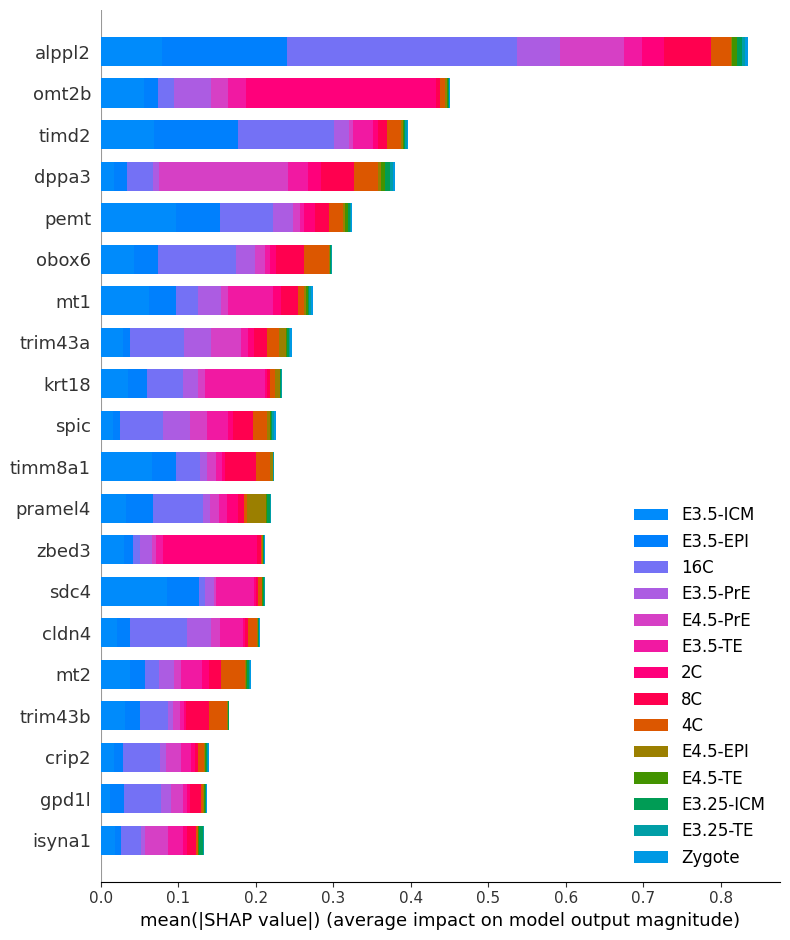

In [10]:
shap.summary_plot(
    shap_values, 
    test['X'], 
    feature_names=lvae.adata.var_names, 
    class_names=lvae.adata.obs.ct.cat.categories
)

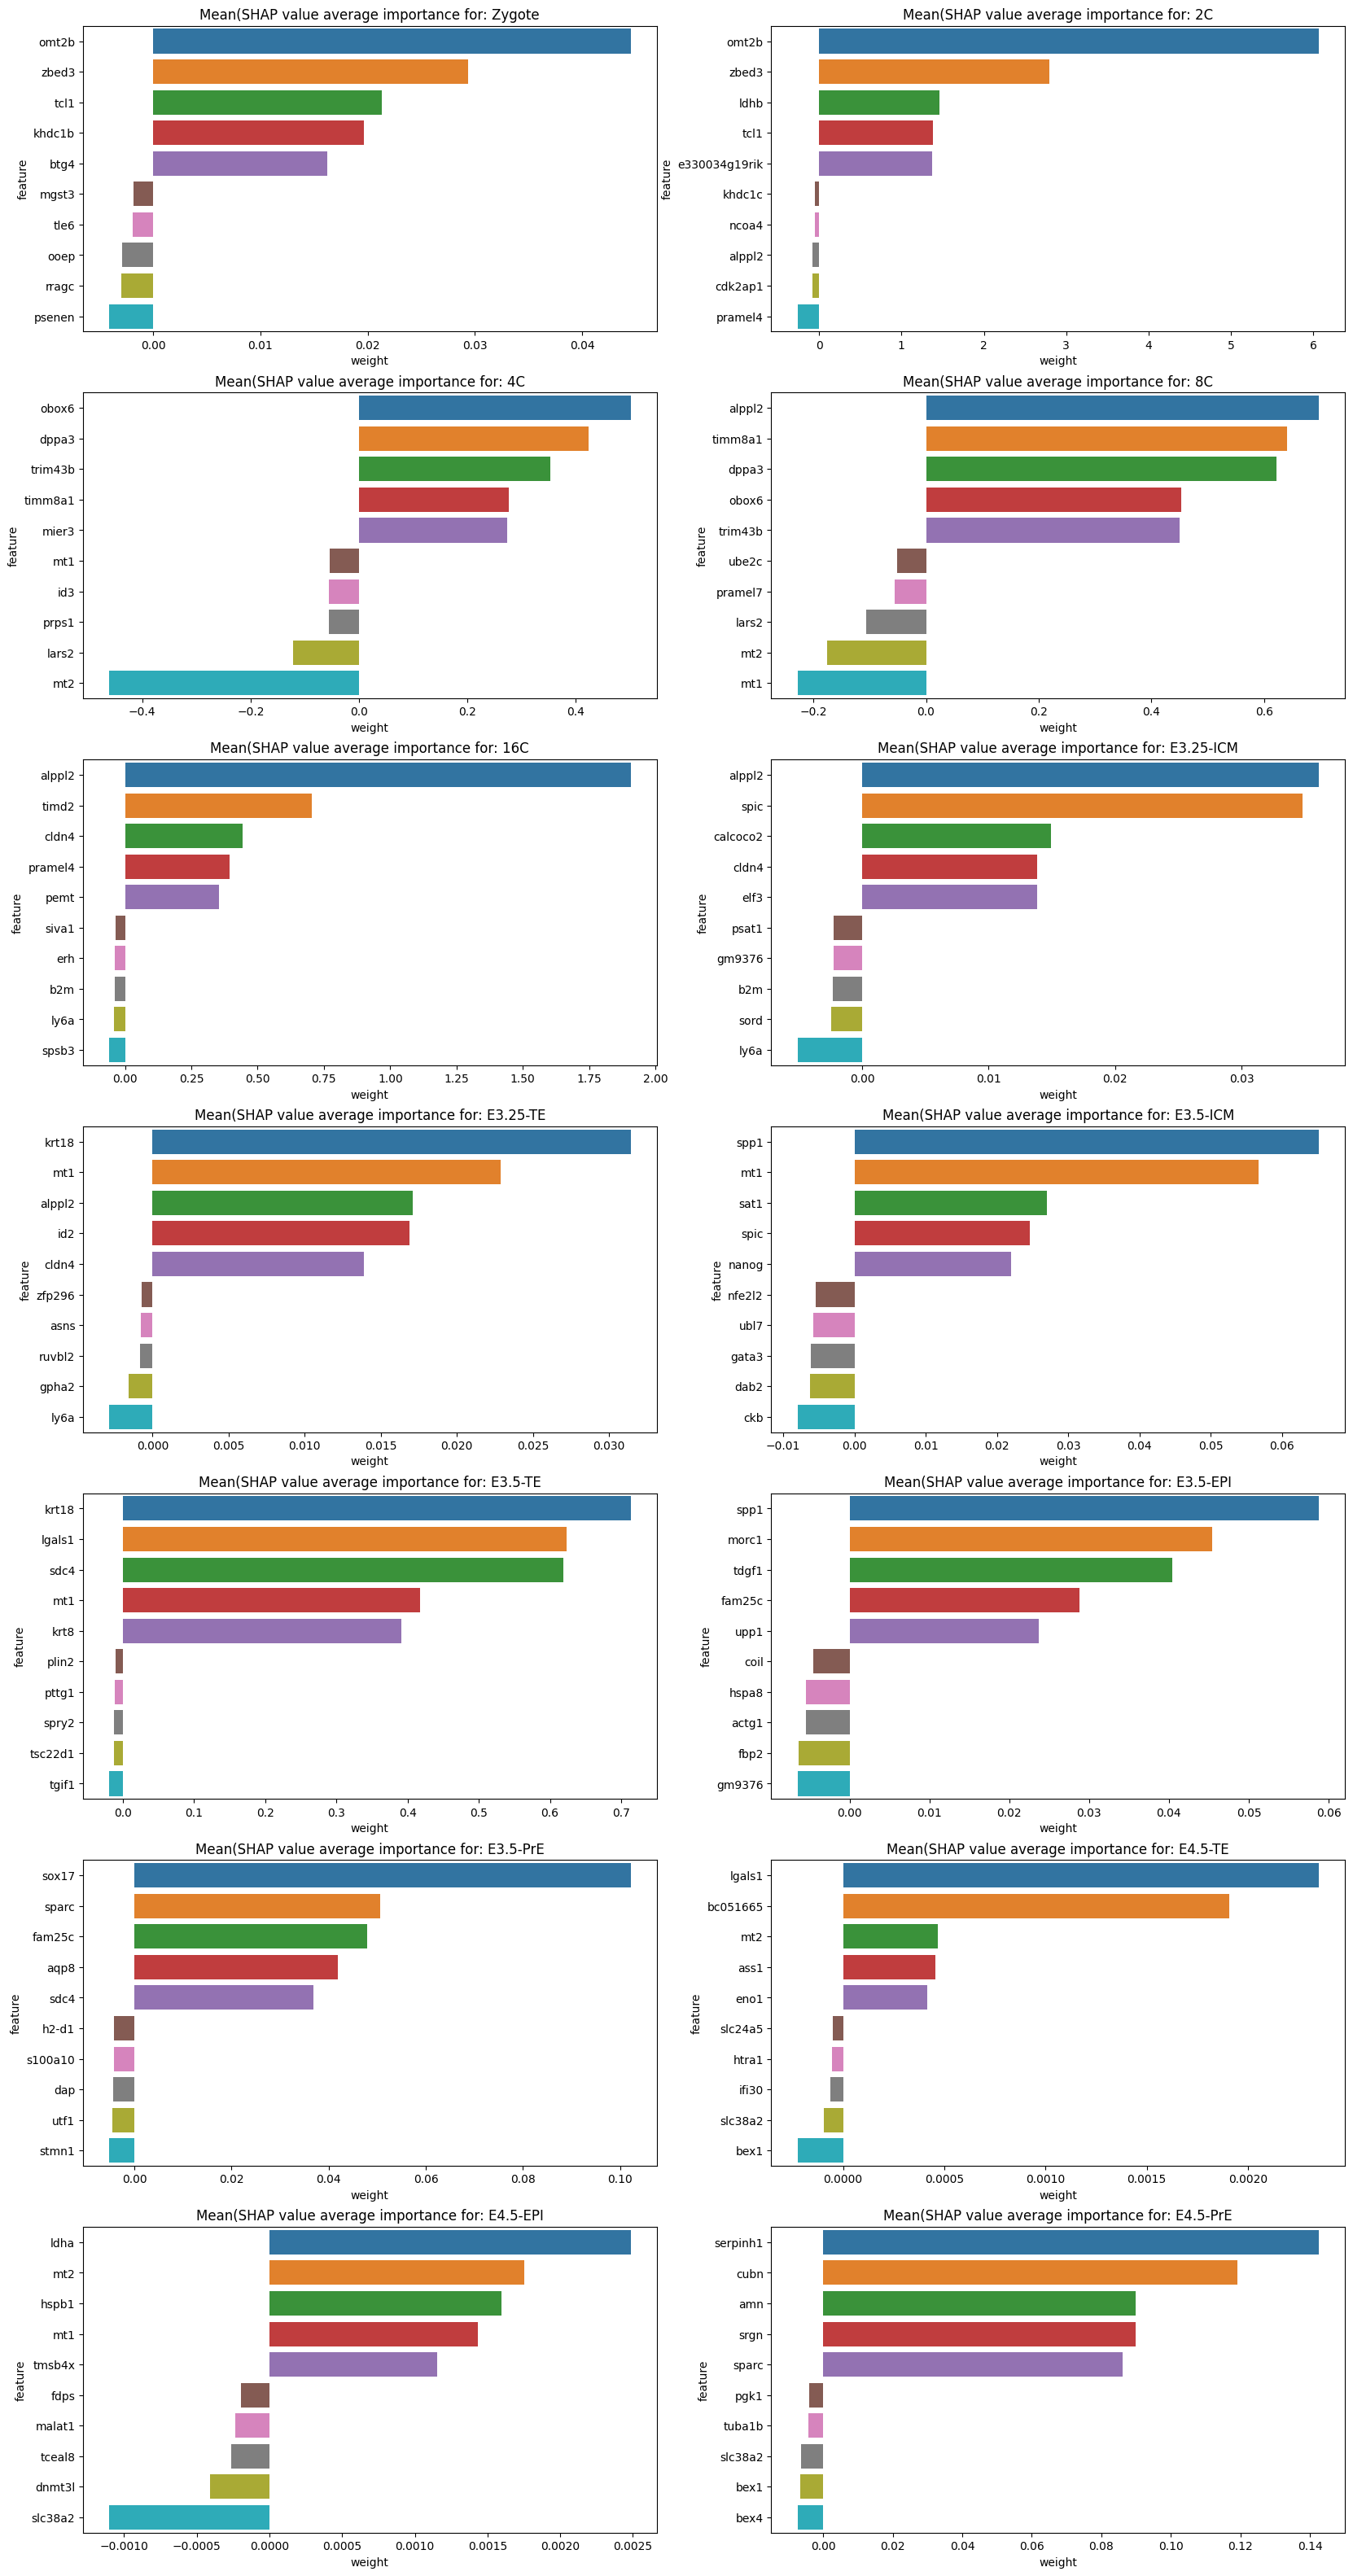

In [24]:
feature_plot(test, shap_values, classes=lvae.adata.obs.ct.cat.categories, features=lvae.adata.var_names, subset=True)

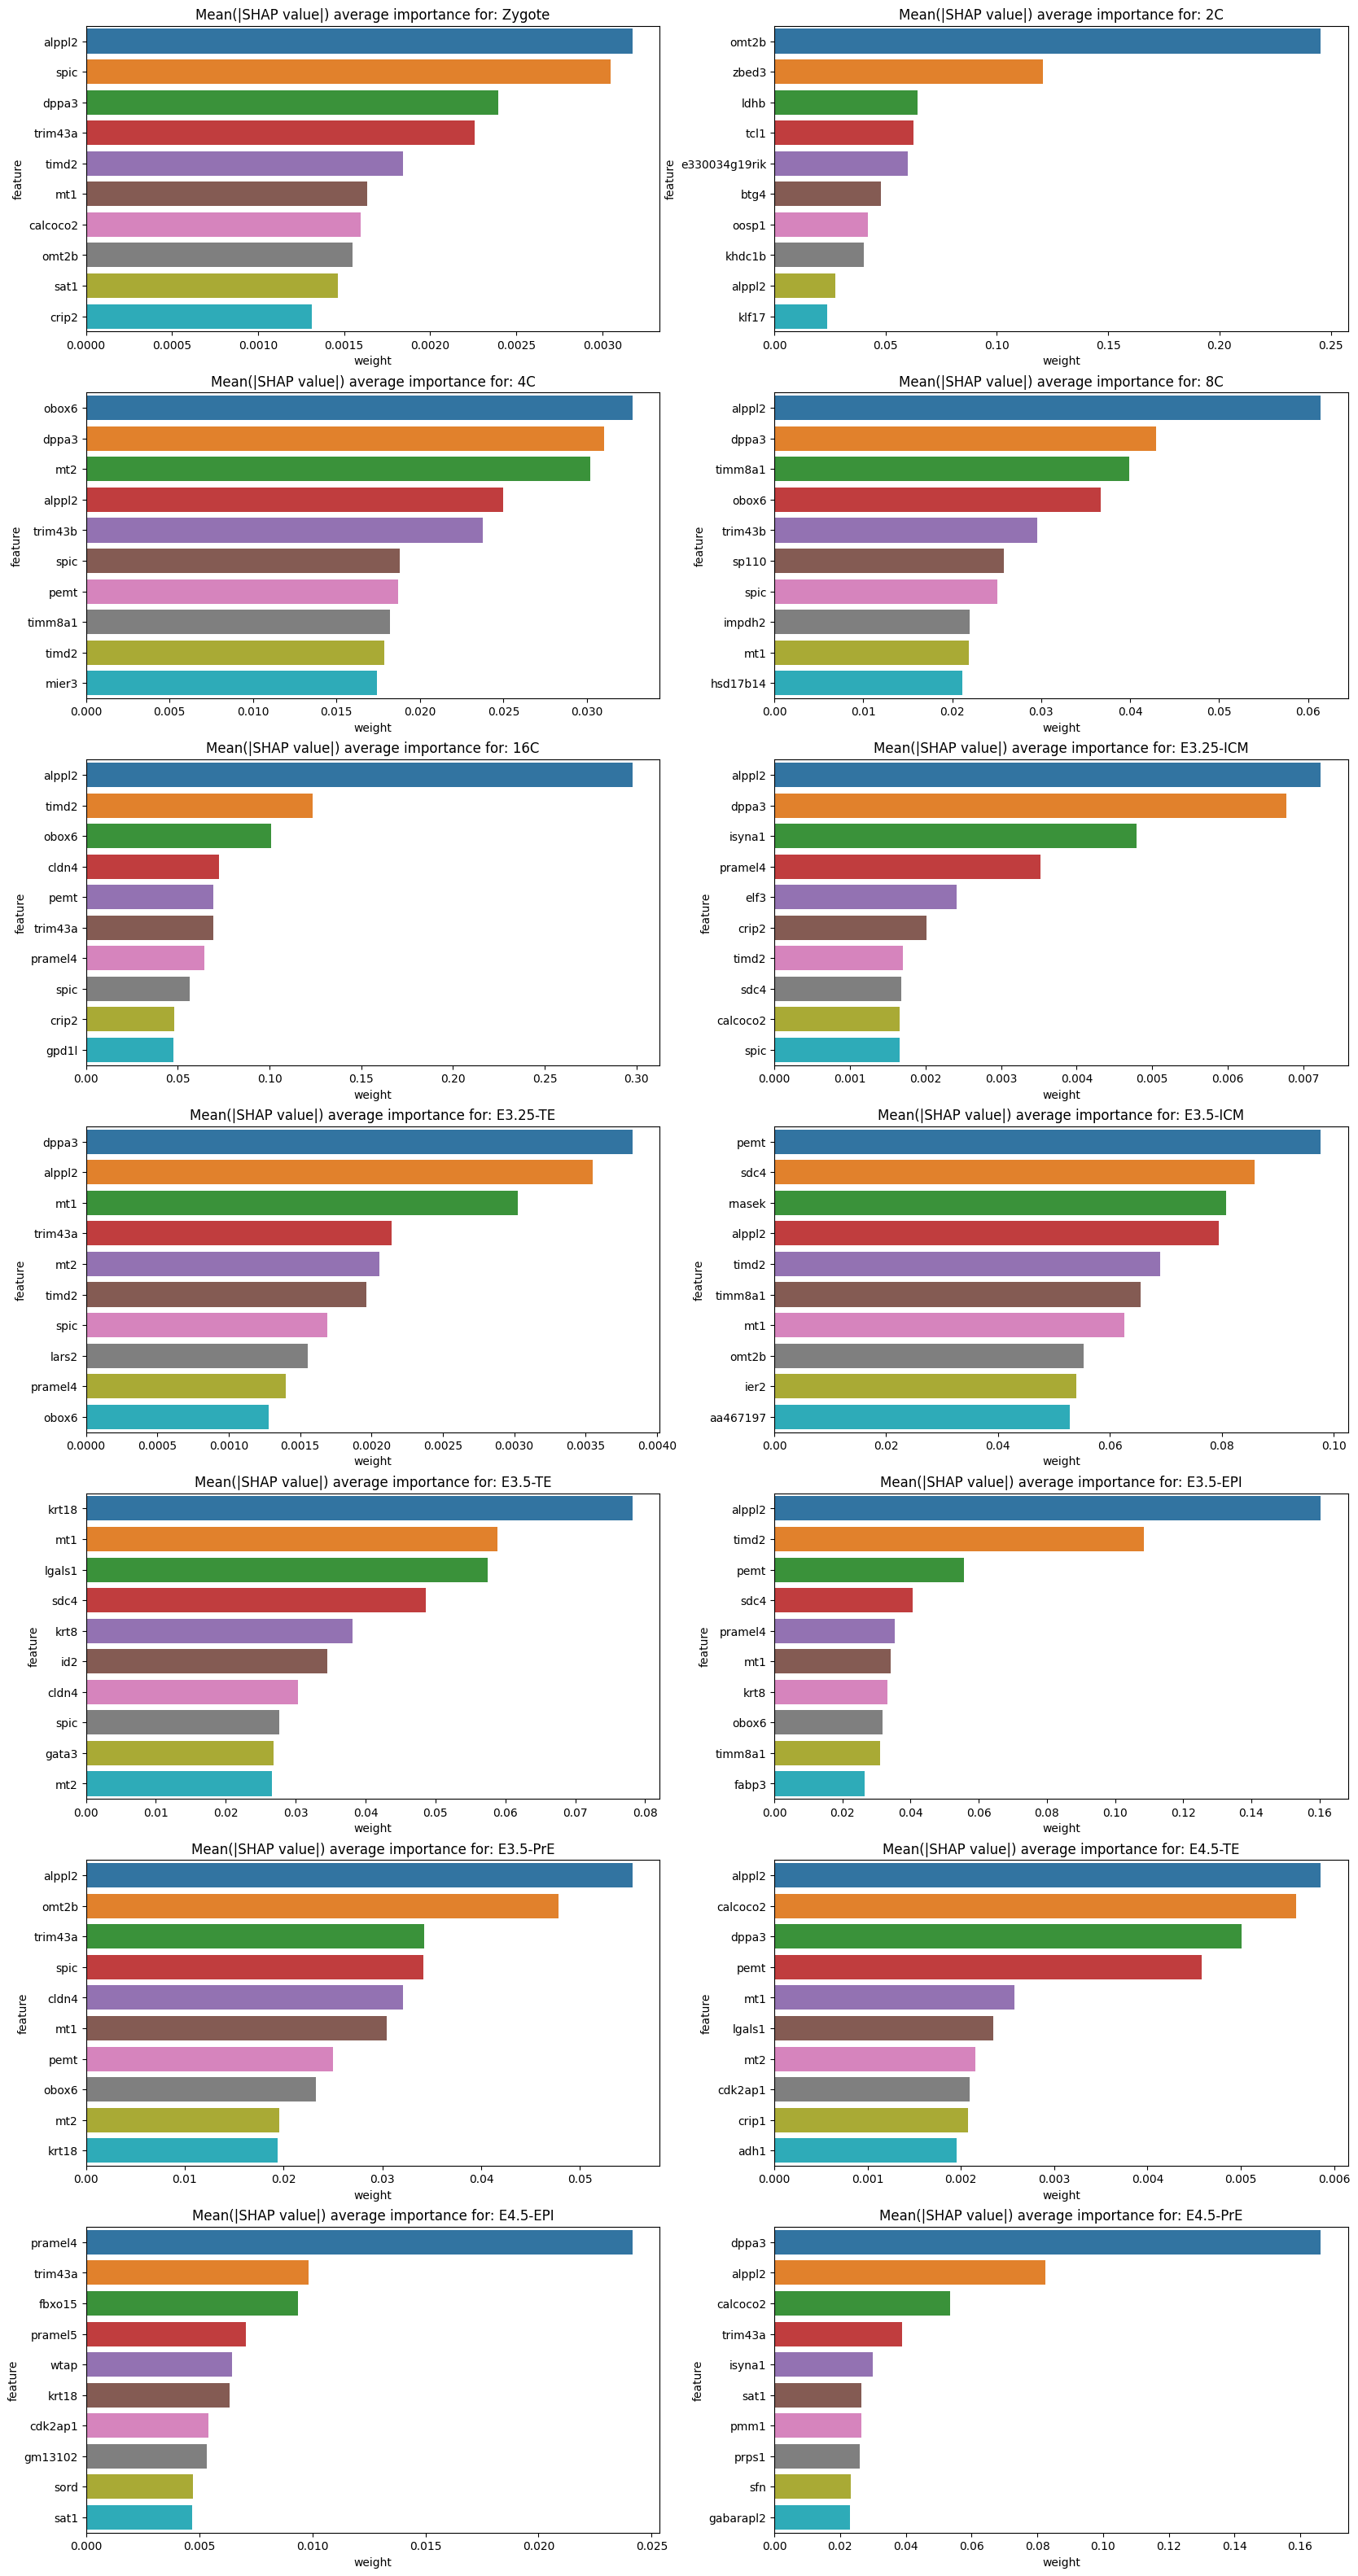

In [25]:
feature_plot(test, shap_values, classes=lvae.adata.obs.ct.cat.categories, features=lvae.adata.var_names, subset=False)